In [10]:
import os
import sys
sys.path.append('..')
import torch

import pretorched.visualizers as vutils
from pretorched.models import utils as mutils
import core
import models
from data import VideoFolder, transforms
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
device = 'cpu' if torch.cuda.is_available() else 'cpu'

In [12]:
data_root = os.environ.get('DATA_ROOT', '')
part_dir = os.path.join(data_root, 'DeepfakeDetection', 'facenet_videos', 'dfdc_train_part_0')
videos = os.listdir(part_dir)

In [13]:
datadir = os.path.join(part_dir, videos[1])
dataset = VideoFolder(datadir, step=12, transform=transforms.get_transform(split='val'))
print(dataset)

Dataset VideoFolder
  Root dir: /data/datasets/DeepfakeDetection/facenet_videos/dfdc_train_part_0/bqefygjsnx.mp4
  Number of datapoints: 2
  Transforms (if any): Compose(
                           Compose(
                           ResizeVideo(size=256, interpolation=PIL.Image.BILINEAR)
                           CenterCropVideo(size=(224, 224))
                       )
                           CollectFrames()
                           PILVideoToTensor(rescale=True, ordering='CTHW')
                           NormalizeVideo(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], channel_dim=0)
                       )



In [14]:
ckpt_file = 'weights/FrameDetector_ssamxresnet18_all_TSNFrameSampler_seg_count-16_init-imagenet-ortho_optim-Ranger_lr-0.001_sched-CosineAnnealingLR_bs-72_best.pth.tar'
ckpt_file = 'weights/FrameDetector_samxresnet18_all_ClipSampler_seg_count-16_init-imagenet-ortho_optim-Ranger_lr-0.001_sched-CosineAnnealingLR_bs-24_best.pth.tar'
model = models.AttnFrameDetector(model=core.get_basemodel('samxresnet18'), normalize=False)
ckpt = torch.load(ckpt_file,  map_location='cpu')
state_dict = mutils.remove_prefix(ckpt['state_dict'])
model.load_state_dict(state_dict, strict=False)
model = model.to(device)
model.eval()

AttnFrameDetector(
  (model): MXResNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): ResBlock(
          (convs): Sequential(
            (0): Sequential(
              (0): Conv2d(64, 64, ke

In [22]:
name, frames, target = dataset[0]
frames = frames.unsqueeze(0).to(device)
input = frames.clone()
print(input.min(), input.mean(), input.max())

tensor(-2.0007) tensor(-0.4864) tensor(2.1633)


In [23]:
for n in model.named_modules():
    print(n[0])


model
model.features
model.features.0
model.features.0.0
model.features.0.1
model.features.0.2
model.features.1
model.features.1.0
model.features.1.1
model.features.2
model.features.2.0
model.features.2.1
model.features.3
model.features.4
model.features.4.0
model.features.4.0.convs
model.features.4.0.convs.0
model.features.4.0.convs.0.0
model.features.4.0.convs.0.1
model.features.4.0.convs.1
model.features.4.0.convs.1.0
model.features.4.0.convs.1.1
model.features.4.1
model.features.4.1.sa
model.features.4.1.sa.theta
model.features.4.1.sa.phi
model.features.4.1.sa.g
model.features.4.1.sa.o
model.features.4.1.convs
model.features.4.1.convs.0
model.features.4.1.convs.0.0
model.features.4.1.convs.0.1
model.features.4.1.convs.1
model.features.4.1.convs.1.0
model.features.4.1.convs.1.1
model.features.5
model.features.5.0
model.features.5.0.convs
model.features.5.0.convs.0
model.features.5.0.convs.0.0
model.features.5.0.convs.0.1
model.features.5.0.convs.1
model.features.5.0.convs.1.0
model.

In [24]:
hooks = [
    {
        'name': 'model.features.4.1.sa.o',
        'type': 'forward',
    }
]
fhooks = mutils.FeatureHooks(hooks, model.named_modules())

In [25]:
with torch.no_grad():
    input = input.to(device)
    out, attn_map = model(input)
    x = fhooks.get_output(out.device)[0]

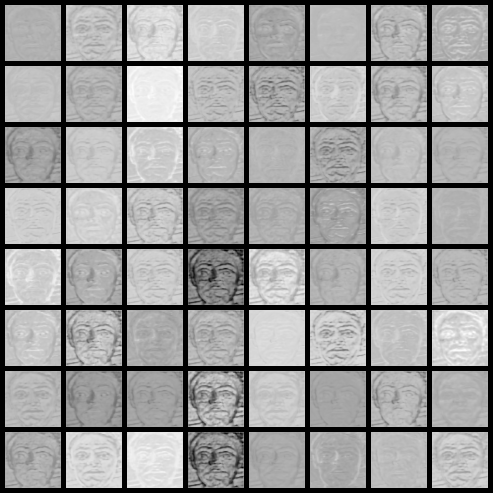

In [26]:

vutils.visualize_samples(x.transpose(0, 1), normalize=True)

In [19]:
with torch.no_grad():
    input = input.to(device)
    out, attn_map = model(input)
    x = fhooks.get_output(out.device)[0]
    self = model.model.features[4][1].sa
    theta = self.theta(x)
    phi = F.max_pool2d(self.phi(x), [2, 2])
    g = F.max_pool2d(self.g(x), [2, 2])
    
    print('theta', theta.shape)
    print('phi', phi.shape)
    print('g', g.shape)

    # Perform reshapes
    theta = theta.view(-1, self.ch // 8, x.shape[2] * x.shape[3])
    phi = phi.view(-1, self.ch // 8, x.shape[2] * x.shape[3] // 4)
    g = g.view(-1, self.ch // 2, x.shape[2] * x.shape[3] // 4)

    # Matmul and softmax to get attention maps
    beta = F.softmax(torch.bmm(theta.transpose(1, 2), phi), -1)
#     beta = torch.bmm(theta.transpose(1, 2), phi)
    print(beta.shape)
    o = torch.bmm(g, beta.transpose(1, 2)).view(-1, self.ch // 2, x.shape[2], x.shape[3])
    o = self.o(o)
    # beta = beta.view(, x.shape[2], x.shape[3])
    # b1 = beta.view(-1, x.shape[2], x.shape[2])
    # beta = beta.view(1, 45, 45, -1).transpose(0, 3).squeeze(-1)
    
    print(beta.shape)
    # print(b1.shape)
    print(o.shape)
    out = self.gamma * o + x

KeyboardInterrupt: 

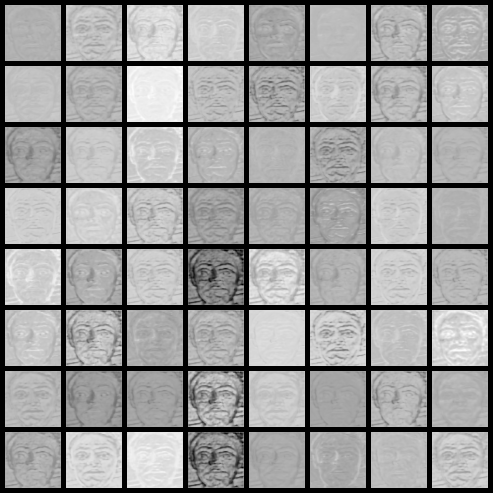

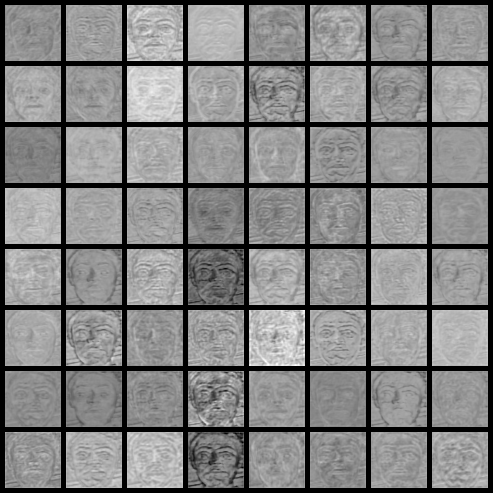

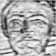

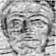

In [9]:
# print(o.min(), o.mean(), o.max())
# print(out.min(), out.mean(), out.max())
# beta = beta.view(-1, x.shape[2], x.shape[3])
# print(beta.shape)
# vutils.visualize_samples(beta.unsqueeze(1).repeat(1, 3, 1, 1), nrow=45, normalize=False)
vutils.visualize_samples(o.transpose(0, 1), normalize=True)
vutils.visualize_samples(out.transpose(0, 1))
vutils.visualize_samples(o.transpose(0, 1).mean(0,  keepdim=True))
vutils.visualize_samples(out.transpose(0, 1).mean(0,  keepdim=True))
# o -= o.min()
# o /= o.max()
# print(o.min(), o.mean(), o.max())k
# vutils.visualize_samples(o.transpose(0, 1), normalize=False)

0.0 255.0 90.483635


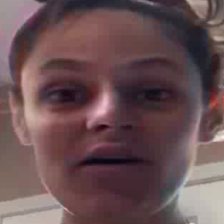

torch.Size([1, 64, 56, 56])
torch.Size([1, 56, 56])


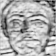

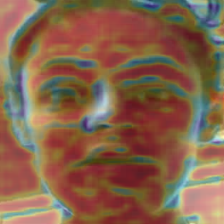

In [10]:
f = frames[0, :, -1].permute(1, 2, 0).numpy() 
f -= f.min()
f /= f.max()
f = f * 255
print(f.min(), f.max(), f.mean())
vutils.imshow(f)
print(o.shape)
oo = o.mean(1)
oo -= oo.min()
oo /= oo.max()
print(oo.shape)
vutils.visualize_samples(oo)
oo = oo.squeeze().numpy()
vutils.imshow(vutils.grad_cam.apply_heatmap(oo.squeeze() , f))

torch.Size([1, 64, 56, 56])


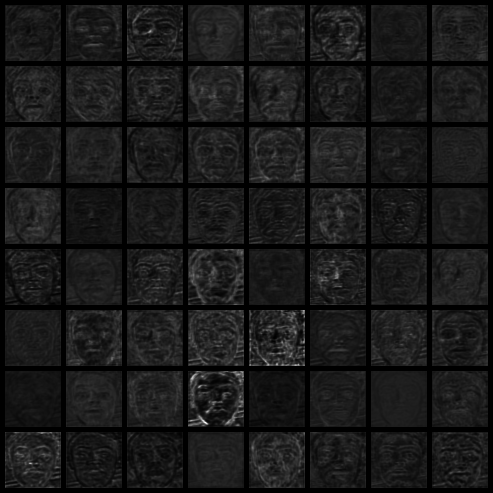

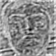

In [11]:
print(x.shape)
# attn_map = F.softmax(x.view(1, 64, -1), dim=-1).view(x.shape).sum(1)
attn_map = x.sum(1)
# attn_map -= attn_map.min()
# attn_map /= attn_map.max()k
# print(y.shape)
# attn_map = y.transpose(0, 1).sum(0, keepdim=True)
vutils.visualize_samples(F.softmax(x, 1).transpose(0, 1))
vutils.visualize_samples(attn_map)

In [12]:

# vutils.imshow()
f = frames[0, :, -1].permute(1, 2, 0).numpy() * 255
print(f.shape)
# vutils.imshow(f)
# a = attn_map - attn_map.min()
# a /= a.max()


(224, 224, 3)


In [13]:
vutils.visualize_samples( x[-1] +(o * self.gamma.detach()).transpose(0, 1).repeat(1, 3, 1, 1).mean(0, keepdim=True))
(o * self.gamma.detach()).transpose(0, 1).repeat(1, 3, 1, 1)
# vutils.visualize_samples(beta.unsqueeze(1).repeat(1, 3, 1, 1), nrow=90)
# vutils.visualize_samples(b1.unsqueeze(1).repeat(1, 3, 1, 1), nrow=45)
# all_vs = []
# for i in range(45):
#     for j in range(45):
#         v = b[:, :, :, i, j].unsqueeze(1).repeat(1, 1, 1, 1)
#         # if i == j:
#         all_vs.append(v)
#         # vutils.visualize_samples(v)
#     break
# vutils.visualize_samples(torch.stack(all_vs).sum(0), normalize=False)
        # vutils.visualize_samples(beta[:, i, j].unsqueeze(1).repeat(1, 3, 1, 1))

RuntimeError: The size of tensor a (64) must match the size of tensor b (3) at non-singleton dimension 1

In [ ]:
self.gamma

In [ ]:
# with torch.no_grad():
#     x = x.to(device)
#     out, attn_map = model(x)
#     sa_input = fhooks.get_output(x.device)[0]
#     print(sa_input.shape)
#     bs, d, h, w = attn_map.size()
#     attn_map = attn_map.view(bs, d, -1)
#     attn_map = F.softmax(attn_map, dim=-1)
#     attn_map = attn_map.view(bs, d, h, w)
#     print(attn_map.shape)
# #     attn_map = F.softmax(attn_map, dim=0)

In [ ]:
attn_map = fhooks.get_output(x.device)[0]

In [ ]:
m = attn_map.transpose(0, 1).repeat(1, 3, 1, 1)
print(m.shape)

In [ ]:
print(m.min(), m.mean(), m.max())

In [ ]:
vutils.visualize_samples(m, nrow=8)

In [ ]:
vutils.visualize_samples(frames.squeeze(0).transpose(0, 1), nrow=5)